In [1]:
# Import the  libraries 
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.initializers import Constant
from keras.models import Model
from keras.layers import *
from keras.utils.np_utils import to_categorical
import re

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
#Getting the dataset
url_tr="https://raw.githubusercontent.com/cacoderquan/Sentiment-Analysis-on-the-Rotten-Tomatoes-movie-review-dataset/master/train.tsv"
data=pd.read_csv(url_tr,sep='\t')
data.head(10)

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
5,6,1,of escapades demonstrating the adage that what...,2
6,7,1,of,2
7,8,1,escapades demonstrating the adage that what is...,2
8,9,1,escapades,2
9,10,1,demonstrating the adage that what is good for ...,2


In [0]:
#Splitting the datset in 70:30 ratio for train & test
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.3, random_state=2003)

In [4]:
train['Sentiment'].value_counts()

2    55595
3    23055
1    19203
4     6468
0     4921
Name: Sentiment, dtype: int64

In [0]:
# optional blog for upsampling & downsampling
from sklearn.utils import resample
train_2 = train[train['Sentiment']==2]
train_1 = train[train['Sentiment']==1]
train_3 = train[train['Sentiment']==3]
train_4 = train[train['Sentiment']==4]
train_5 = train[train['Sentiment']==0]
#train_2_sample = resample(train_2,replace=True,n_samples=30000,random_state=123)
#train_1_sample = resample(train_1,replace=True,n_samples=4924,random_state=123)
#train_3_sample = resample(train_3,replace=True,n_samples=4924,random_state=123)
#train_4_sample = resample(train_4,replace=True,n_samples=10000,random_state=123)
#train_5_sample = resample(train_5,replace=True,n_samples=10000,random_state=123)

#df_upsampled = pd.concat([train_2, train_1,train_3,train_4_sample,train_5_sample])
#df_upsampled.head()

In [0]:
# extract full sentences only from the dataset
fullSentences = []
curSentence = 0
for i in range(data.shape[0]):
  if data['SentenceId'][i]> curSentence:
    fullSentences.append((data['Phrase'][i], data['Sentiment'][i]))
    curSentence = curSentence +1


In [0]:
# put data into a df
fullSentDf = pd.DataFrame(fullSentences,
                                columns=['Phrase', 'Sentiment'])


In [8]:
# Check class imbalance in full sentences
fullSentDf['Sentiment'].value_counts()

3    2325
1    2203
2    1659
4    1282
0    1075
Name: Sentiment, dtype: int64

In [0]:
X_train=train["Phrase"]
Y_train=train["Sentiment"]
X_test=test["Phrase"]
Y_test=test["Sentiment"]

In [10]:
# preprocessing of dataset
import nltk
import random
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer, LancasterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

def  Preprocess_data(X,Y):
 
 documents = []
 for i in range(len(X)):
   tmpWords = word_tokenize(X.values[i])
   documents.append((tmpWords, Y.values[i]))
 random.seed(9001)
 random.shuffle(documents)
 porter = PorterStemmer()
 lancaster=LancasterStemmer()
 wordnet_lemmatizer = WordNetLemmatizer()
 stopwords_en = stopwords.words("english")
 punctuations="?:!.,;'\"-()"
 remove_stopwords = True
 useStemming = True
 useLemma = False
 removePuncs = True
 for l in range(len(documents)):
  label = documents[l][1]
  tmpReview = []
  for w in documents[l][0]:
    newWord = w
    if remove_stopwords and (w in stopwords_en):
      continue
    if removePuncs and (w in punctuations):
      continue
    if useStemming:
      #newWord = porter.stem(newWord)
      newWord = lancaster.stem(newWord)
    if useLemma:
      newWord = wordnet_lemmatizer.lemmatize(newWord)
    tmpReview.append(newWord)
  documents[l] = (' '.join(tmpReview), label)
  all_data = pd.DataFrame(documents,
                                columns=['text', 'sentiment'])

  return all_data

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [0]:
all_data = Preprocess_data(X_train,Y_train)

In [12]:
all_data

,text,sentiment
0,world trad cent tragedy,2
1,"[impossible, spot]",1
2,"[constructed, than, ``, Memento, '']",2
3,"[found, myself]",2
4,"[The, most, horrific, movie, experience]",0
...,...,...
109237,"[terrible, ,, banal, dialogue]",1
109238,"[It, 's, pretty, linear, and, only, makeup-dee...",2
109239,"[what, experiences, you, bring, to, it]",2
109240,"[some, difficult, relationships]",1


In [0]:
all_data['text']=[" ".join(text) for text in all_data['text'].values]

In [0]:
all_data1 = Preprocess_data(X_test,Y_test)

In [0]:
all_data1['text']=[" ".join(text) for text in all_data1['text'].values]

In [0]:
#TF-IDF
vectorizer = TfidfVectorizer(stop_words="english",
                            ngram_range=(1, 1),max_features=2000)

In [0]:
X_trainF = vectorizer.fit_transform(all_data["text"])
Y_trainF= all_data['sentiment']
Y_trainF = to_categorical(Y_trainF.values)

In [0]:
X_testF = vectorizer.fit_transform(all_data1["text"])
Y_testF= all_data1['sentiment']
Y_testF = to_categorical(Y_testF.values)

In [19]:
print(X_trainF.shape)
print(Y_trainF.shape)
print(X_testF.shape)
print(Y_testF.shape)

(109242, 2000)
(109242, 5)
(46818, 2000)
(46818, 5)


In [20]:
#CNN model
from keras.layers import Input, Dense, Embedding, Flatten
from keras.layers import SpatialDropout1D
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.models import Sequential
from keras import regularizers

model = Sequential()
max_features = 20000
sequence_length = 2000

# Input / Embdedding
model.add(Embedding(max_features, 300, input_length=sequence_length,trainable=True))

# CNN

model.add(SpatialDropout1D(0.2))

model.add(Conv1D(32, kernel_size=3, padding='same', activation='relu'))
model.add(Dropout(rate = 0.50))
model.add(MaxPooling1D(pool_size=2))


model.add(Conv1D(64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))



#model.add(Dropout(rate = 0.50))
#model.add(Bidirectional(GRU(32, return_sequences = True))
model.add(Flatten())

# Output layer
model.add(Dense(5, activation='softmax'))





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2000, 300)         6000000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 2000, 300)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2000, 32)          28832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 2000, 32)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1000, 32)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1000, 64)          6208      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 500, 64)          

In [0]:
#function for F1 score ,precsion, recall
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [23]:
# compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc',f1_m,precision_m, recall_m])

In [32]:
history = model.fit(X_trainF, Y_trainF, epochs=10, batch_size=64, verbose=1, validation_split=0.1, shuffle=True)


Train on 98317 samples, validate on 10925 samples
Epoch 1/10
98317/98317 [==============================] - 53s 544us/step - loss: 1.2159 - acc: 0.5216 - f1_m: 0.2657 - precision_m: 0.6796 - recall_m: 0.1797 - val_loss: 1.2676 - val_acc: 0.5026 - val_f1_m: 0.2303 - val_precision_m: 0.6847 - val_recall_m: 0.1400
Epoch 2/10
98317/98317 [==============================] - 53s 543us/step - loss: 1.2139 - acc: 0.5225 - f1_m: 0.2613 - precision_m: 0.6872 - recall_m: 0.1733 - val_loss: 1.2724 - val_acc: 0.5000 - val_f1_m: 0.2216 - val_precision_m: 0.6797 - val_recall_m: 0.1339
Epoch 3/10
98317/98317 [==============================] - 53s 544us/step - loss: 1.2131 - acc: 0.5234 - f1_m: 0.2624 - precision_m: 0.6887 - recall_m: 0.1743 - val_loss: 1.2719 - val_acc: 0.5026 - val_f1_m: 0.2296 - val_precision_m: 0.6812 - val_recall_m: 0.1398
Epoch 4/10
98317/98317 [==============================] - 53s 542us/step - loss: 1.2116 - acc: 0.5227 - f1_m: 0.2682 - precision_m: 0.6837 - recall_m: 0.1811 - v

In [25]:
scores=model.evaluate(X_testF,Y_testF,verbose=1)

46818/46818 [==============================] - 6s 125us/step


In [26]:
print("Accuracy:")
print(scores[1])
print("F1-Score:")
print(scores[2])
print("Precision:")
print(scores[3])
print("recall:")
print(scores[4])


Accuracy:
0.50559613823743
F1-Score:
0.2082713372638415
Precision:
0.615920461004825
recall:
0.127920885129651


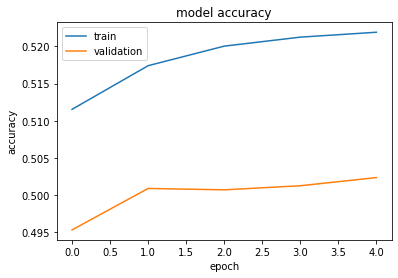

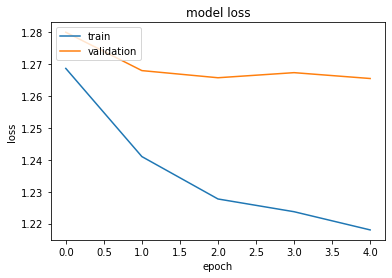

In [27]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [28]:
model.save("model_1115467.h5")
print("Saved model to disk")


Saved model to disk


In [29]:
from numpy import loadtxt
from keras.models import load_model
# load model
model1 = load_model('model_1115467.h5', custom_objects={'f1_m':f1_m,'precision_m':precision_m,'recall_m':recall_m })
# summarize model
model1.summary()




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2000, 300)         6000000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 2000, 300)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2000, 32)          28832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 2000, 32)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1000, 32)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1000, 64)          6208      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 500, 64)          

In [30]:
#evaluting the model loaded

scores=model1.evaluate(X_testF,Y_testF,verbose=1)

46818/46818 [==============================] - 6s 126us/step


In [31]:
print("Accuracy:")
print(scores[1])
print("F1-Score:")
print(scores[2])
print("Precision:")
print(scores[3])
print("recall:")
print(scores[4])


Accuracy:
0.50559613823743
F1-Score:
0.2082713372638415
Precision:
0.615920461004825
recall:
0.127920885129651
